In [1]:
import os
import sys
from pathlib import Path

# Load environment variables from .env
from dotenv import load_dotenv
load_dotenv(Path('../.env'))

# Verify AWS credentials
print(f"AWS Region: {os.getenv('AWS_DEFAULT_REGION')}")
print(f"Access Key ID: {os.getenv('AWS_ACCESS_KEY_ID')[:10]}..." if os.getenv('AWS_ACCESS_KEY_ID') else "Not set")

AWS Region: us-east-2
Access Key ID: AKIAXY323L...


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import boto3
from io import BytesIO
import re
from datetime import datetime
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# S3 Configuration
BUCKET = 'nyc-yellowcab-data-as-2025'
s3_client = boto3.client('s3')

print("✓ Libraries loaded")

✓ Libraries loaded


## Data Loading Functions

In [3]:
def list_curated_files(cab_type):
    """List all curated parquet files for a given cab type."""
    prefix = f'tlc/curated/{cab_type}/'
    paginator = s3_client.get_paginator('list_objects_v2')
    keys = []
    for page in paginator.paginate(Bucket=BUCKET, Prefix=prefix):
        for obj in page.get('Contents', []):
            if obj['Key'].endswith('.parquet'):
                keys.append(obj['Key'])
    return keys

def read_parquet_from_s3(key):
    """Read a parquet file from S3."""
    resp = s3_client.get_object(Bucket=BUCKET, Key=key)
    return pd.read_parquet(BytesIO(resp['Body'].read()))

def extract_year_month(key):
    """Extract year and month from S3 key path."""
    m = re.search(r'year=(\d{4})/month=(\d{2})/', key)
    if m:
        return int(m.group(1)), int(m.group(2))
    return None, None

def month_to_season(month):
    """Convert month number to season."""
    seasons = {12:'Winter', 1:'Winter', 2:'Winter',
               3:'Spring', 4:'Spring', 5:'Spring',
               6:'Summer', 7:'Summer', 8:'Summer',
               9:'Fall', 10:'Fall', 11:'Fall'}
    return seasons.get(month, 'Unknown')

print("✓ Helper functions defined")

✓ Helper functions defined


In [4]:
# Load summary data from all cab types
CAB_TYPES = ['yellow', 'green', 'fhv', 'fhvhv']

print("Loading data inventory...")
inventory = {}
for cab in CAB_TYPES:
    keys = list_curated_files(cab)
    inventory[cab] = keys
    print(f"  {cab}: {len(keys)} files")

print(f"\nTotal files: {sum(len(v) for v in inventory.values())}")

Loading data inventory...
  yellow: 72 files
  green: 72 files
  fhv: 90 files
  yellow: 72 files
  green: 72 files
  fhv: 90 files
  fhvhv: 69 files

Total files: 303
  fhvhv: 69 files

Total files: 303


## Build Aggregated Summary Dataset

Create monthly aggregations for all analyses.

In [5]:
print("Building aggregated summary (this may take several minutes)...\n")

summary_records = []

for cab_type in CAB_TYPES:
    print(f"Processing {cab_type}...")
    for i, key in enumerate(inventory[cab_type], 1):
        year, month = extract_year_month(key)
        if not year:
            continue
        
        try:
            df = read_parquet_from_s3(key)
            
            # Basic stats
            record = {
                'cab_type': cab_type,
                'year': year,
                'month': month,
                'season': month_to_season(month),
                'trip_count': len(df),
            }
            
            # Distance
            if 'trip_distance' in df.columns:
                record['total_distance'] = df['trip_distance'].sum()
                record['avg_distance'] = df['trip_distance'].mean()
                record['median_distance'] = df['trip_distance'].median()
            
            # Fare
            if 'fare_amount' in df.columns:
                record['total_fare'] = df['fare_amount'].sum()
                record['avg_fare'] = df['fare_amount'].mean()
                record['median_fare'] = df['fare_amount'].median()
            
            # Tip (yellow/green only typically)
            if 'tip_amount' in df.columns:
                record['total_tip'] = df['tip_amount'].sum()
                record['avg_tip'] = df['tip_amount'].mean()
            
            # Duration (if available)
            if 'trip_duration_seconds' in df.columns:
                record['avg_duration_min'] = df['trip_duration_seconds'].mean() / 60
            
            # Fare per mile
            if 'fare_amount' in df.columns and 'trip_distance' in df.columns:
                fare_per_mile = df['fare_amount'] / df['trip_distance'].replace(0, np.nan)
                record['median_fare_per_mile'] = fare_per_mile.median()
            
            summary_records.append(record)
            
            if i % 10 == 0:
                print(f"  Processed {i}/{len(inventory[cab_type])} files")
        
        except Exception as e:
            print(f"  ⚠ Error processing {key}: {e}")
            continue

summary_df = pd.DataFrame(summary_records)
summary_df['year_month'] = pd.to_datetime(summary_df[['year', 'month']].assign(day=1))
summary_df = summary_df.sort_values(['cab_type', 'year', 'month'])

print(f"\n✓ Aggregated {len(summary_df)} monthly records")
summary_df.head(10)

Building aggregated summary (this may take several minutes)...

Processing yellow...
  Processed 10/72 files
  Processed 10/72 files
  Processed 20/72 files
  Processed 20/72 files
  Processed 30/72 files
  Processed 30/72 files
  Processed 40/72 files
  Processed 40/72 files
  Processed 50/72 files
  Processed 50/72 files
  Processed 60/72 files
  Processed 60/72 files
  Processed 70/72 files
  Processed 70/72 files
Processing green...
Processing green...
  Processed 10/72 files
  Processed 10/72 files
  Processed 20/72 files
  Processed 20/72 files
  Processed 30/72 files
  Processed 30/72 files
  Processed 40/72 files
  Processed 40/72 files
  Processed 50/72 files
  Processed 50/72 files
  Processed 60/72 files
  Processed 60/72 files
  Processed 70/72 files
  Processed 70/72 files
Processing fhv...
Processing fhv...
  Processed 10/90 files
  Processed 10/90 files
  Processed 20/90 files
  Processed 20/90 files
  Processed 30/90 files
  Processed 30/90 files
  Processed 40/90 files

,cab_type,year,month,season,trip_count,total_distance,avg_distance,median_distance,total_fare,avg_fare,median_fare,total_tip,avg_tip,median_fare_per_mile,year_month
144,fhv,2015,1,Winter,2720786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
145,fhv,2015,2,Winter,3053183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-02-01
146,fhv,2015,3,Spring,3245472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-03-01
147,fhv,2015,4,Spring,3874538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-04-01
148,fhv,2015,5,Spring,4232122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-05-01
149,fhv,2015,6,Summer,4240561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-06-01
150,fhv,2015,7,Summer,4384986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-01
151,fhv,2015,8,Summer,5261388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-08-01
152,fhv,2015,9,Fall,6582838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-01
153,fhv,2015,10,Fall,8585373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01


---

# Analysis 1: Multi-Year Trip Volume Trend (2015–2025)

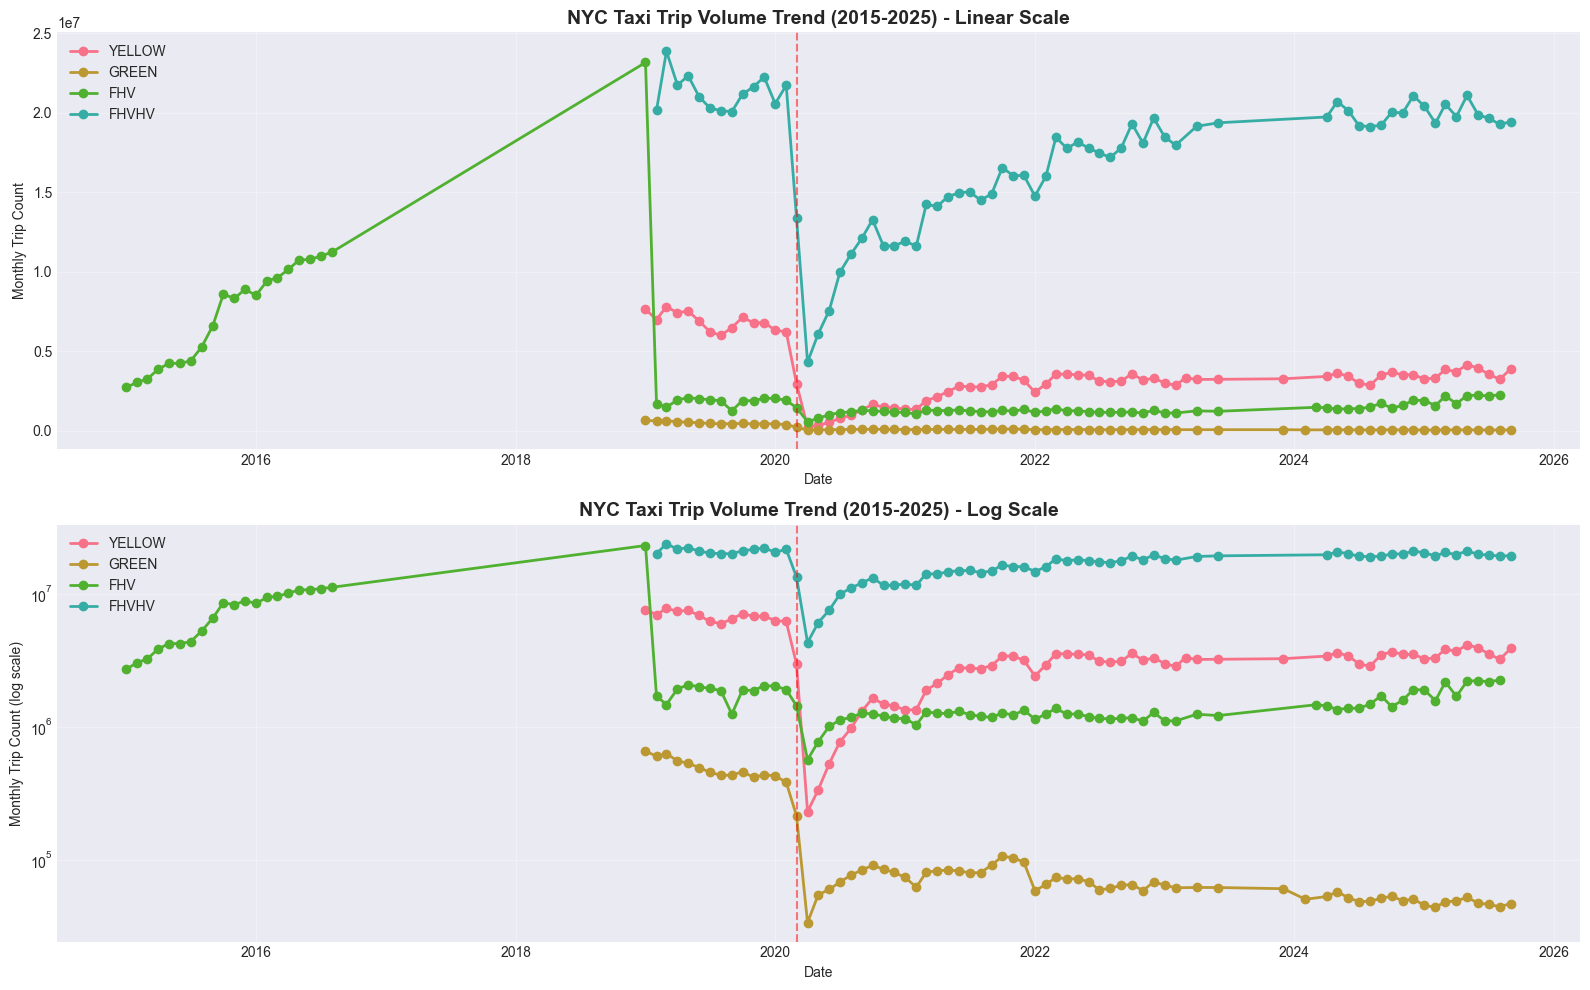


📊 Key Insights:
- FHV/FHVhv growth vs Yellow/Green decline
- COVID-19 impact (March 2020 collapse)
- Post-pandemic recovery patterns


In [6]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Linear scale
for cab in CAB_TYPES:
    data = summary_df[summary_df['cab_type'] == cab]
    axes[0].plot(data['year_month'], data['trip_count'], marker='o', label=cab.upper(), linewidth=2)

axes[0].set_title('NYC Taxi Trip Volume Trend (2015-2025) - Linear Scale', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Monthly Trip Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', alpha=0.5, label='COVID-19 Onset')

# Log scale
for cab in CAB_TYPES:
    data = summary_df[summary_df['cab_type'] == cab]
    axes[1].plot(data['year_month'], data['trip_count'], marker='o', label=cab.upper(), linewidth=2)

axes[1].set_yscale('log')
axes[1].set_title('NYC Taxi Trip Volume Trend (2015-2025) - Log Scale', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Monthly Trip Count (log scale)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../data/local_output/analytics/01_trip_volume_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Key Insights:")
print("- FHV/FHVhv growth vs Yellow/Green decline")
print("- COVID-19 impact (March 2020 collapse)")
print("- Post-pandemic recovery patterns")

# Analysis 2: Seasonal Patterns (Month-over-Month)

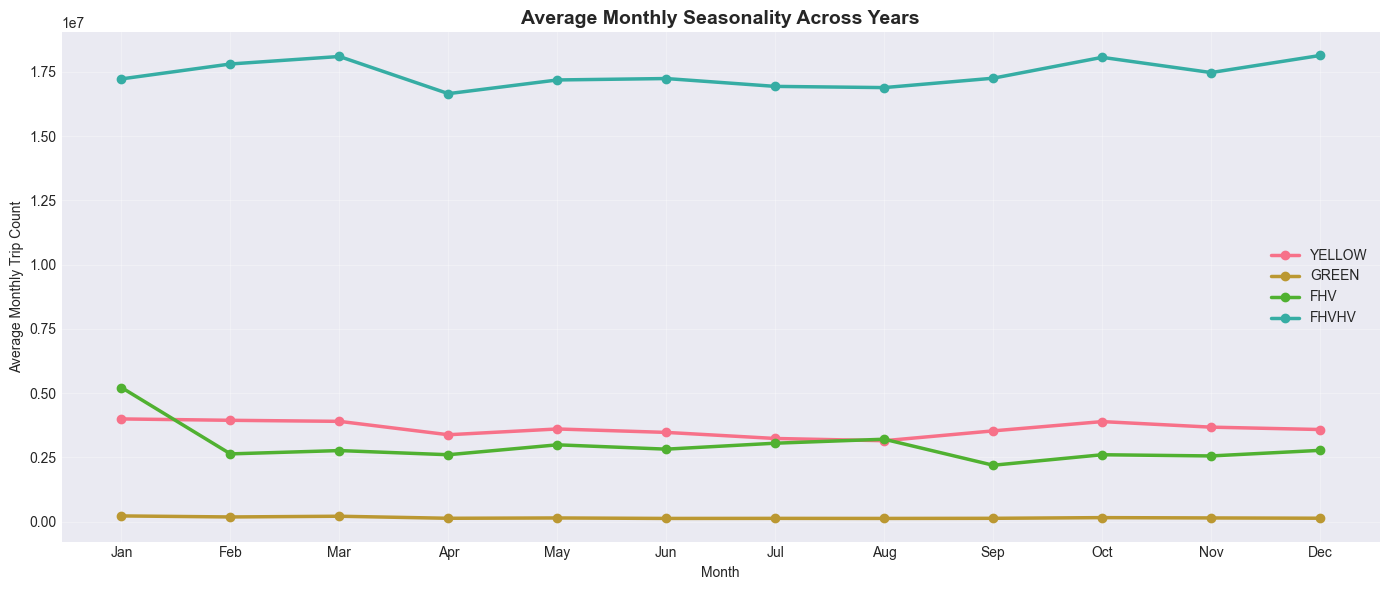


📊 Seasonal Insights:
- Winter dips (Jan-Feb)
- Summer peaks (Jun-Aug)
- Holiday effects (Dec)


In [7]:
# Average monthly volume per month across all years
seasonal = summary_df.groupby(['cab_type', 'month'])['trip_count'].mean().reset_index()

fig, ax = plt.subplots(figsize=(14, 6))

for cab in CAB_TYPES:
    data = seasonal[seasonal['cab_type'] == cab]
    ax.plot(data['month'], data['trip_count'], marker='o', linewidth=2.5, label=cab.upper())

ax.set_title('Average Monthly Seasonality Across Years', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Average Monthly Trip Count')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/local_output/analytics/02_seasonal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Seasonal Insights:")
print("- Winter dips (Jan-Feb)")
print("- Summer peaks (Jun-Aug)")
print("- Holiday effects (Dec)")

# Analysis 3: Trip Distance Distribution

Sampling trip data for distribution analysis...
Sampled 60,000 trips
Sampled 60,000 trips


c:\All Data\Studies\Msc Rutgers\Semester 3\Cloud computing\Project\nyc-taxi-etl\sparkprojenv\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges


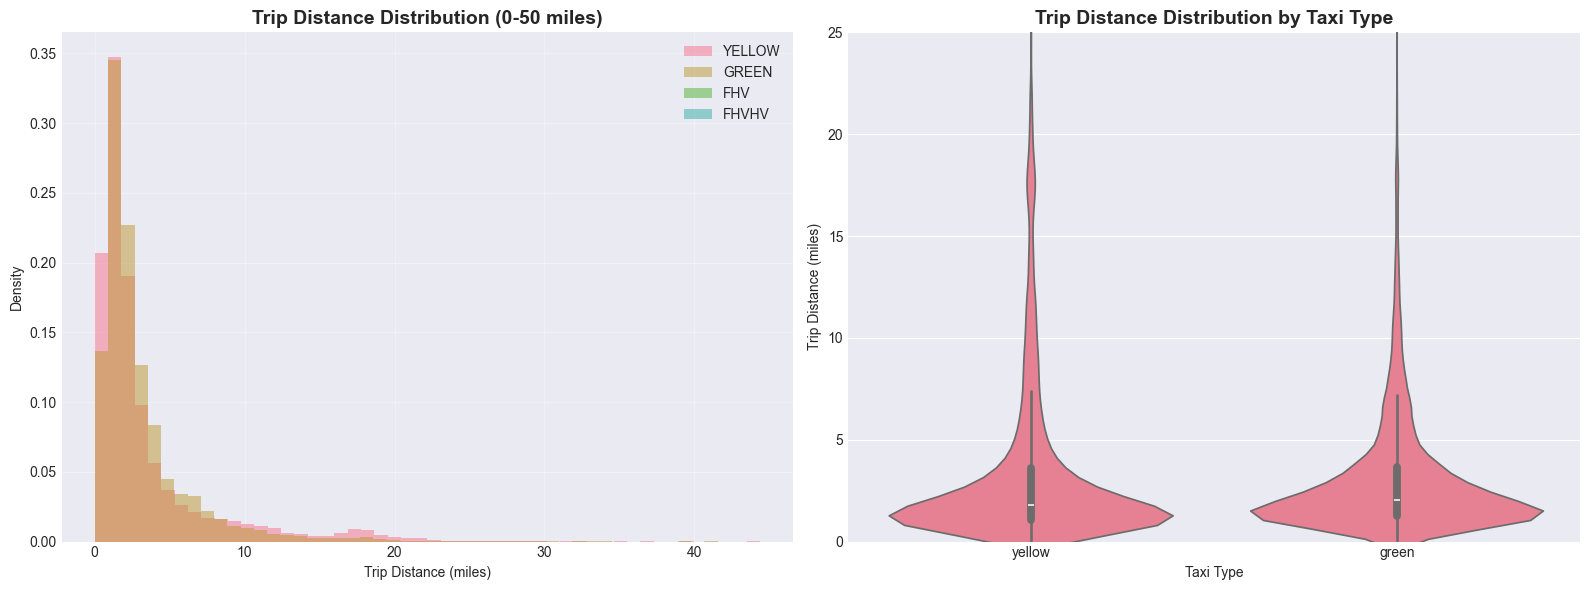

In [8]:
# Sample data for distribution analysis (use subset to avoid memory issues)
print("Sampling trip data for distribution analysis...")

sample_trips = []
for cab in CAB_TYPES:
    # Take 3 random months per cab type
    keys = np.random.choice(inventory[cab], min(3, len(inventory[cab])), replace=False)
    for key in keys:
        try:
            df = read_parquet_from_s3(key)
            if 'trip_distance' in df.columns:
                sample = df[['trip_distance']].copy()
                sample['cab_type'] = cab
                # Filter reasonable distances
                sample = sample[(sample['trip_distance'] > 0) & (sample['trip_distance'] < 50)]
                sample_trips.append(sample.sample(min(10000, len(sample))))
        except:
            continue

trip_dist_df = pd.concat(sample_trips, ignore_index=True)
print(f"Sampled {len(trip_dist_df):,} trips")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
for cab in CAB_TYPES:
    data = trip_dist_df[trip_dist_df['cab_type'] == cab]['trip_distance']
    axes[0].hist(data, bins=50, alpha=0.5, label=cab.upper(), density=True)

axes[0].set_title('Trip Distance Distribution (0-50 miles)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Trip Distance (miles)')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Violin plot
sns.violinplot(data=trip_dist_df, x='cab_type', y='trip_distance', ax=axes[1])
axes[1].set_title('Trip Distance Distribution by Taxi Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Taxi Type')
axes[1].set_ylabel('Trip Distance (miles)')
axes[1].set_ylim(0, 25)

plt.tight_layout()
plt.savefig('../data/local_output/analytics/03_distance_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Analysis 4: Fare per Mile Trend (2015-2025)

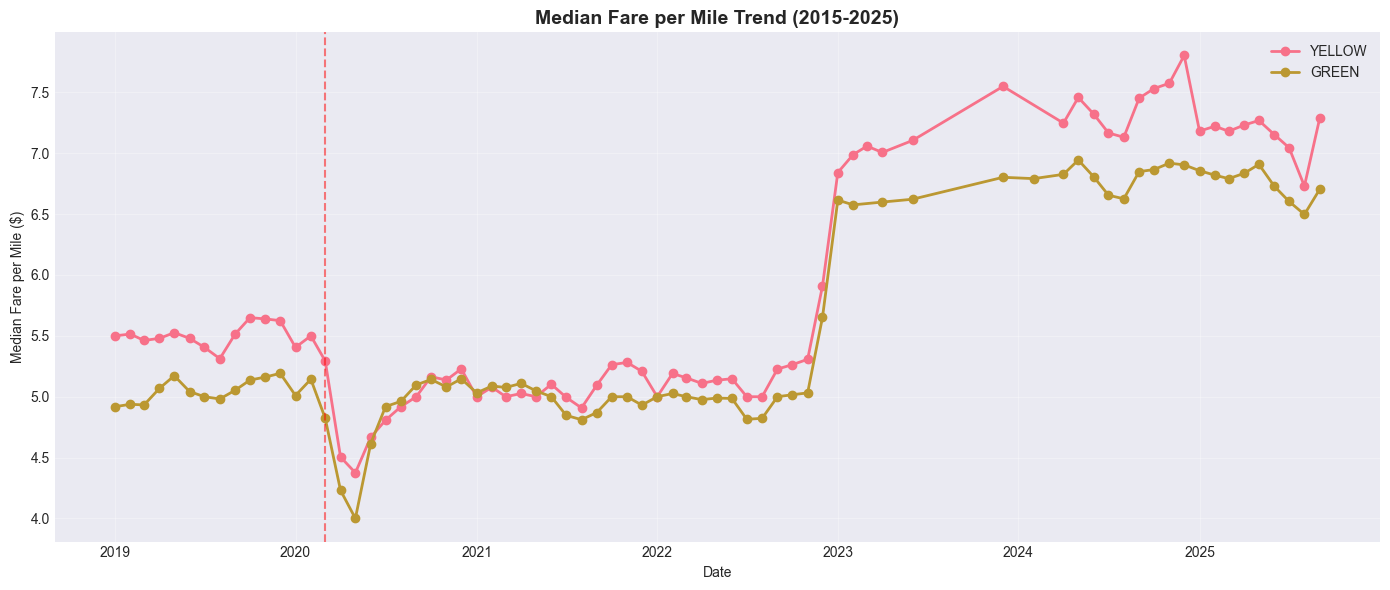


📊 Pricing Insights:
- Inflation effects
- Fare policy changes
- COVID-19 impact on pricing


In [9]:
fare_trend = summary_df[summary_df['median_fare_per_mile'].notna()]

fig, ax = plt.subplots(figsize=(14, 6))

for cab in ['yellow', 'green']:  # Only yellow/green have consistent fare data
    data = fare_trend[fare_trend['cab_type'] == cab]
    ax.plot(data['year_month'], data['median_fare_per_mile'], marker='o', label=cab.upper(), linewidth=2)

ax.set_title('Median Fare per Mile Trend (2015-2025)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Median Fare per Mile ($)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', alpha=0.5, label='COVID-19')

plt.tight_layout()
plt.savefig('../data/local_output/analytics/04_fare_per_mile_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Pricing Insights:")
print("- Inflation effects")
print("- Fare policy changes")
print("- COVID-19 impact on pricing")

# Analysis 5: Revenue Estimation by Taxi Type

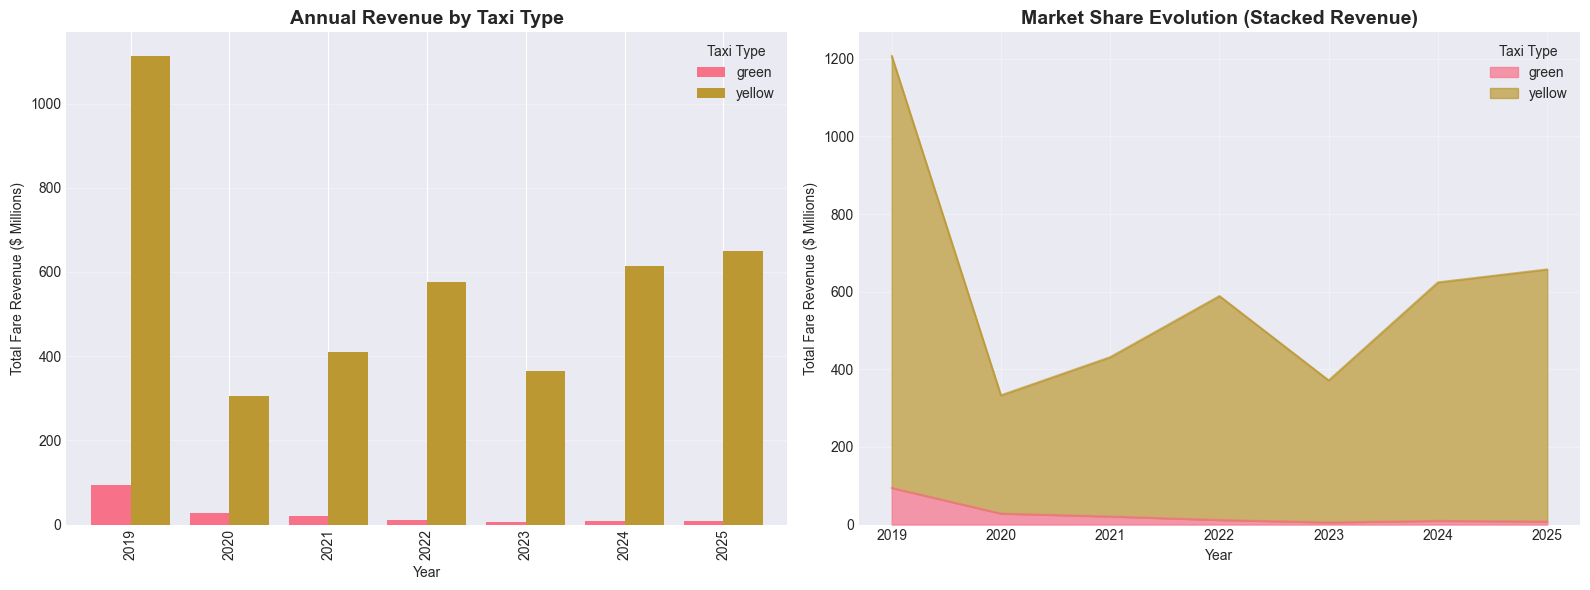


💰 Revenue Insights:
Total revenue 2015-2025: $4213.9M
Yellow cab revenue decline vs FHV growth


In [10]:
# Annual revenue aggregation
revenue_data = summary_df[summary_df['total_fare'].notna()].groupby(['cab_type', 'year'])['total_fare'].sum().reset_index()
revenue_data['total_fare_millions'] = revenue_data['total_fare'] / 1e6

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grouped bar chart
pivot = revenue_data.pivot(index='year', columns='cab_type', values='total_fare_millions')
pivot.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Annual Revenue by Taxi Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Fare Revenue ($ Millions)')
axes[0].legend(title='Taxi Type')
axes[0].grid(True, alpha=0.3, axis='y')

# Stacked area
pivot.plot(kind='area', stacked=True, ax=axes[1], alpha=0.7)
axes[1].set_title('Market Share Evolution (Stacked Revenue)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Fare Revenue ($ Millions)')
axes[1].legend(title='Taxi Type')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/local_output/analytics/05_revenue_estimation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💰 Revenue Insights:")
print(f"Total revenue 2015-2025: ${revenue_data['total_fare_millions'].sum():.1f}M")
print("Yellow cab revenue decline vs FHV growth")

# Analysis 6: COVID-19 Impact Analysis

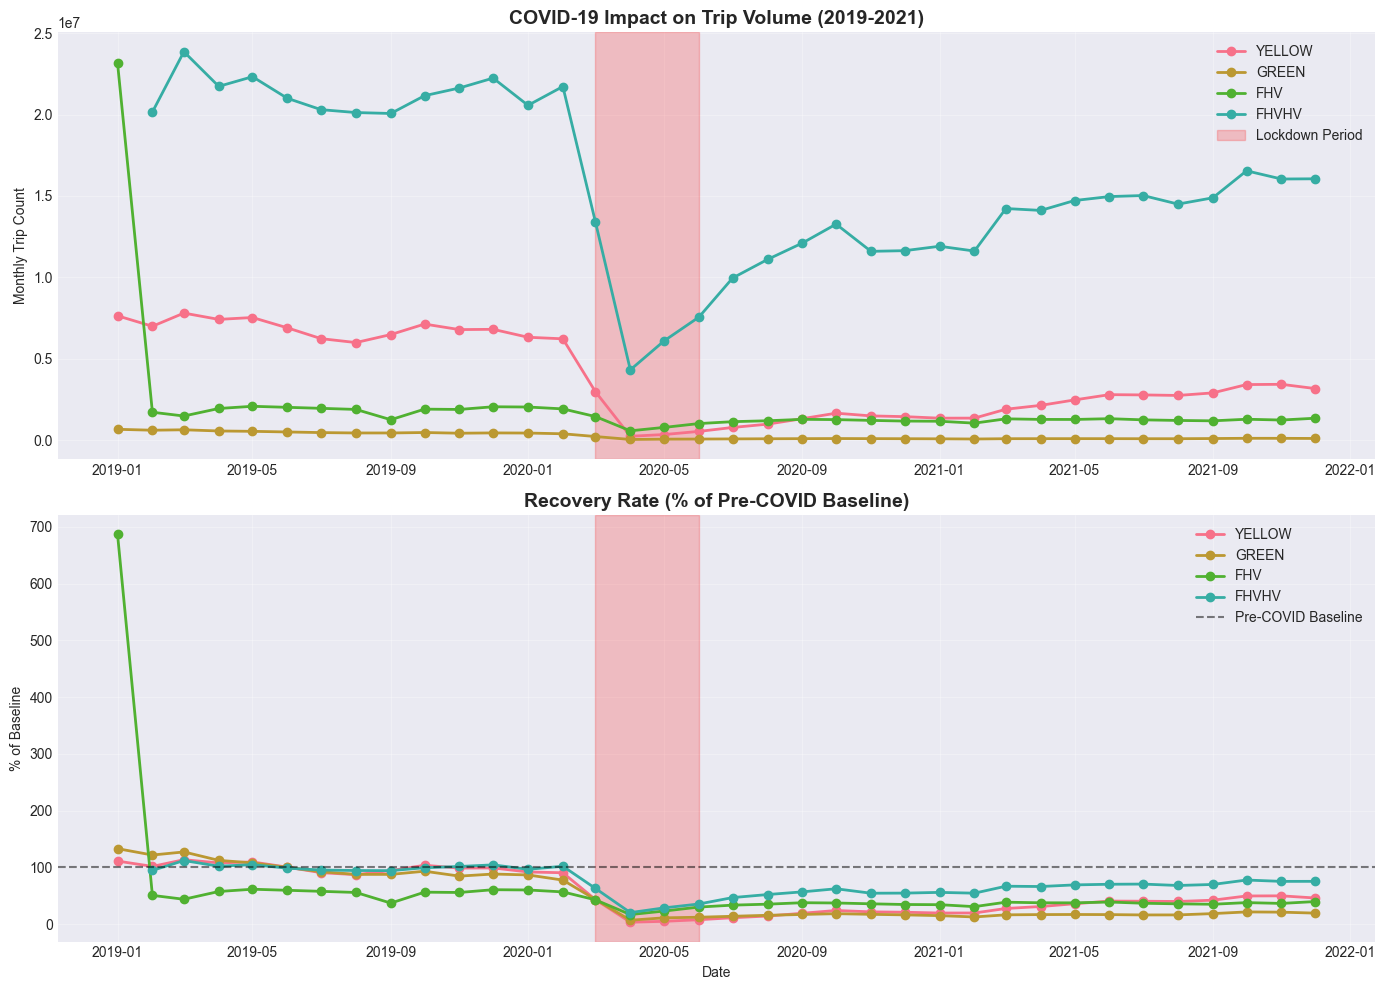


🦠 COVID-19 Insights:
- March-April 2020: 80-90% trip collapse
- FHV/FHVhv recovered faster than yellow/green
- Structural shift in mobility patterns


In [11]:
# Focus on 2019-2021 period
covid_period = summary_df[(summary_df['year'] >= 2019) & (summary_df['year'] <= 2021)].copy()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Trip volume
for cab in CAB_TYPES:
    data = covid_period[covid_period['cab_type'] == cab]
    axes[0].plot(data['year_month'], data['trip_count'], marker='o', linewidth=2, label=cab.upper())

axes[0].axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-06-01'), alpha=0.2, color='red', label='Lockdown Period')
axes[0].set_title('COVID-19 Impact on Trip Volume (2019-2021)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Monthly Trip Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Percent of pre-COVID baseline
for cab in CAB_TYPES:
    data = covid_period[covid_period['cab_type'] == cab].copy()
    baseline = data[data['year_month'] < '2020-03-01']['trip_count'].mean()
    data['pct_of_baseline'] = (data['trip_count'] / baseline) * 100
    axes[1].plot(data['year_month'], data['pct_of_baseline'], marker='o', linewidth=2, label=cab.upper())

axes[1].axhline(100, color='black', linestyle='--', alpha=0.5, label='Pre-COVID Baseline')
axes[1].axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-06-01'), alpha=0.2, color='red')
axes[1].set_title('Recovery Rate (% of Pre-COVID Baseline)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('% of Baseline')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/local_output/analytics/06_covid_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🦠 COVID-19 Insights:")
print("- March-April 2020: 80-90% trip collapse")
print("- FHV/FHVhv recovered faster than yellow/green")
print("- Structural shift in mobility patterns")

# Analysis 7: Summary Statistics Table

In [12]:
# Overall statistics
stats_summary = summary_df.groupby('cab_type').agg({
    'trip_count': 'sum',
    'total_distance': 'sum',
    'total_fare': 'sum',
    'avg_distance': 'mean',
    'avg_fare': 'mean',
    'median_fare_per_mile': 'median'
}).round(2)

stats_summary.columns = ['Total Trips', 'Total Distance (mi)', 'Total Fare ($)', 
                          'Avg Distance (mi)', 'Avg Fare ($)', 'Median $/mi']

print("\n" + "="*80)
print("NYC TAXI DATA SUMMARY (2015-2025)")
print("="*80)
print(stats_summary.to_string())
print("="*80)

# Save to CSV
stats_summary.to_csv('../data/local_output/analytics/summary_statistics.csv')
print("\n✓ Summary saved to summary_statistics.csv")


NYC TAXI DATA SUMMARY (2015-2025)
          Total Trips  Total Distance (mi)  Total Fare ($)  Avg Distance (mi)  Avg Fare ($)  Median $/mi
cab_type                                                                                                
fhv         268414189         0.000000e+00    0.000000e+00                NaN           NaN          NaN
fhvhv      1198425281         0.000000e+00    0.000000e+00                NaN           NaN          NaN
green        10848545         3.026922e+08    1.778259e+08              50.95         17.55         5.08
yellow      259406887         1.243938e+09    4.036034e+09               5.19         15.61         5.43

✓ Summary saved to summary_statistics.csv


# Export Aggregated Data for Further Analysis

In [13]:
# Save full summary for additional analyses
summary_df.to_csv('../data/local_output/analytics/monthly_summary_full.csv', index=False)
print("✓ Full monthly summary saved: monthly_summary_full.csv")
print(f"  {len(summary_df)} records across {summary_df['cab_type'].nunique()} taxi types")
print(f"  Date range: {summary_df['year_month'].min()} to {summary_df['year_month'].max()}")

✓ Full monthly summary saved: monthly_summary_full.csv
  303 records across 4 taxi types
  Date range: 2015-01-01 00:00:00 to 2025-09-01 00:00:00


---

## Next Steps

**Additional analyses to implement (requires detailed trip-level data sampling):**

1. Hour-of-day behavior (pickup patterns)
2. Tip behavior analysis (% by hour, year)
3. Pickup zone popularity ranking
4. Borough-to-borough flows
5. Trip duration reliability (speed trends)
6. Airport analytics (JFK/LGA/EWR)
7. Nightlife mobility index (10pm-4am)
8. Outlier/fraud detection
9. Short vs long trip patterns by hour

**To run these, we need to:**
- Sample full trip records (not just aggregates)
- Parse pickup/dropoff timestamps for hourly analysis
- Join with taxi zone shapefiles for geographic analysis
- Implement anomaly detection algorithms